In [1]:
!make -C .. statpop scenario_prop scenario_config scenario_endpoints

make: Entering directory '/home/martibosch/data-science/lausanne-greening-scenarios'
make: Nothing to be done for 'statpop'.
make: Nothing to be done for 'scenario_prop'.
make: Nothing to be done for 'scenario_config'.
make: Nothing to be done for 'scenario_endpoints'.
make: Leaving directory '/home/martibosch/data-science/lausanne-greening-scenarios'


In [2]:
import tempfile
from os import path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import salem
import seaborn as sns
import swiss_uhi_utils as suhi
import swisslandstats as sls
import xarray as xr
from affine import Affine

In [3]:
agglom_extent_filepath = '../data/raw/agglom-extent/agglom-extent.shp'
statpop_filepath = '../data/raw/statpop/statpop-2019.csv'

scenario_prop_filepath = '../data/processed/scenario-prop.nc'
scenario_config_filepath = '../data/processed/scenario-config.nc'
scenario_endpoints_filepath = '../data/processed/scenario-endpoints.nc'

In [4]:
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
ldf = sls.read_csv(statpop_filepath, x_column='E_KOORD', y_column='N_KOORD')
agglom_ldf = ldf.clip_by_geometry(
    geometry=agglom_extent_gdf.iloc[0]['geometry'],
    geometry_crs=agglom_extent_gdf.crs)
agglom_ldf['total'] = agglom_ldf[[f'B19B{sex}TOT'
                                  for sex in ['M', 'W']]].sum(axis=1)
with tempfile.TemporaryDirectory() as tmp_dir:
    tmp_filepath = path.join(tmp_dir, f'agglom-pop.tif')
    agglom_ldf.to_geotiff(tmp_filepath, 'total')
    agglom_pop_da =  salem.open_xr_dataset(tmp_filepath)['data']

In [5]:
num_plot_cols = 5

change_props = np.linspace(0, 1, num_plot_cols)


def preprocess_scenario_ds(scenario_ds_filepath):
    # change props is curried here
    return xr.open_dataset(scenario_ds_filepath)['T'].sel(
        change_prop=change_props[1:-1])

In [6]:
scenario_T_da = xr.concat([
    preprocess_scenario_ds(scenario_prop_filepath).expand_dims(
        interaction=['none']),
    preprocess_scenario_ds(scenario_config_filepath)
],
                          dim='interaction')
scenario_endpoints_ds = xr.open_dataset(scenario_endpoints_filepath)
scenario_T_da = xr.concat([
    scenario_T_da,
    scenario_endpoints_ds['T'].mean(dim='scenario_run').expand_dims(
        interaction=scenario_T_da['interaction'],
        scenario_run=scenario_T_da['scenario_run'])
],
                          dim='change_prop').sortby('change_prop')
scenario_T_da.attrs.update(
    pyproj_srs=scenario_endpoints_ds.attrs['pyproj_srs'])
# scenario_T_da = suhi.align_ds(scenario_T_da, agglom_pop_da)
scenario_T_da = xr.concat([
    suhi.align_ds(group_T_da, agglom_pop_da)
    for change_prop, group_T_da in scenario_T_da.groupby('change_prop')
],
                          dim='change_prop')

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
T_step = 1
T_ser = pd.Series(np.arange(np.floor(scenario_T_da.min().item()),
                            np.ceil(scenario_T_da.max().item()), T_step),
                  name='T')

In [8]:
change_props = scenario_T_da['change_prop']
interactions = scenario_T_da['interaction'].data
scenario_runs = scenario_T_da['scenario_run'].data
long_df = pd.concat([
    pd.DataFrame(
        pd.DataFrame(np.array([
            agglom_pop_da.where(
                scenario_T_da.sel(interaction=interaction,
                                  scenario_run=scenario_run) > T,
                0).sum(dim=['x', 'y']).data for T in T_ser
        ]),
                     index=T_ser,
                     columns=change_props).stack().rename('count')).assign(
                         interaction=interaction, scenario_run=scenario_run)
    for interaction in interactions for scenario_run in scenario_runs
],
                    axis=0).reset_index()

# get a wide dataframe to compute the difference between cluster and scatter
wide_df = long_df.set_index(list(long_df.columns.difference(
    ['count'])))['count'].unstack('interaction').reset_index()
wide_df['diff'] = (wide_df['cluster'] - wide_df['scatter'])

# compute fraction of the population in the long dataframe
# long_df['pop_frac'] = long_df['count'] / agglom_pop_da.sum().item()

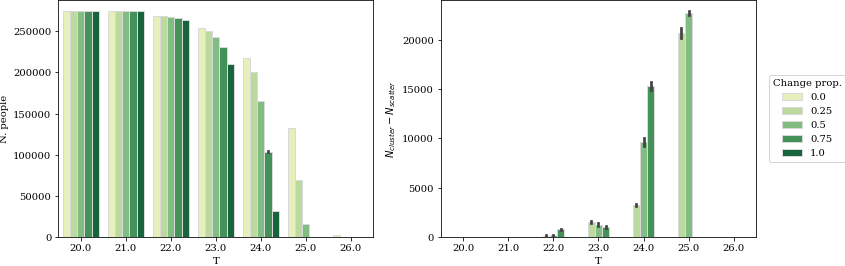

In [9]:
figwidth, figheight = plt.rcParams['figure.figsize']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))

sns.barplot(x='T',
            y='count',
            hue='change_prop',
            data=long_df[long_df['interaction'] == 'none'],
            palette='YlGn',
            ax=ax1)
ax1.set_ylabel('N. people')
legend = ax1.legend()
legend.remove()
sns.barplot(x='T',
            y='diff',
            hue='change_prop',
            data=wide_df,
            palette='YlGn',
            ax=ax2)
ax2.set_ylabel('$N_{cluster} - N_{scatter}$')
ax2.legend(title='Change prop.', loc='center right', bbox_to_anchor=(1.3, .5))

fig.tight_layout(h_pad=1.2)
fig.savefig('../reports/figures/human-exposure.pdf')